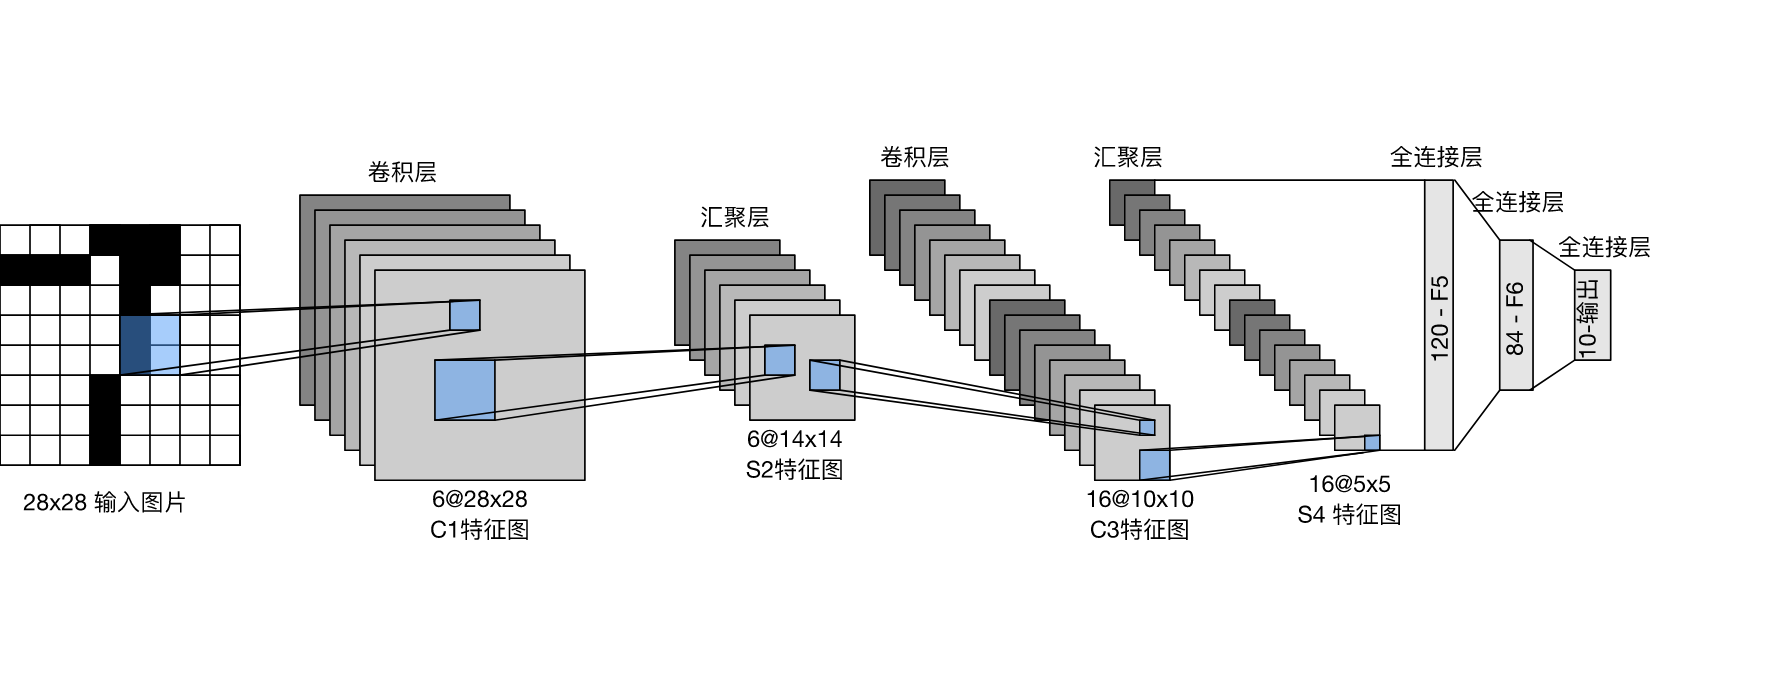

In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: LeNet
# Author: Tracy Tao
# Date: 2022/04/11
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
# 定义模型，连接网络
net = nn.Sequential(nn.Conv2d(1,6, kernel_size = 5, padding = 2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Conv2d(6,16, kernel_size = 5),nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),nn.Flatten(),
                    nn.Linear(16 *5*5,120),nn.Sigmoid(),
                    nn.Linear(120,84),nn.Sigmoid(),nn.Linear(84,10))

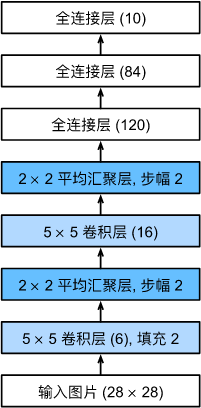

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
# 使用gpu
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [6]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # 正态规范化
    net.apply(init_weights) # 对网络使用正态规范函数
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 初始化随机梯度下降优化器
    loss = nn.CrossEntropyLoss() # 初始化交叉熵损失函数
    animator = d2l.Animator(xlabel='epoch', 
                            xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc']) # 损失图可视化
    timer, num_batches = d2l.Timer(), len(train_iter) # 初始化计时器和批量数
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # 训练损失之和，训练准确率之和，样本数
        net.train() # 使用模型训练数据
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad() # 初始化优化器梯度
            X, y = X.to(device), y.to(device)
            y_hat = net(X) # 计算当前层的输出
            l = loss(y_hat, y) 
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.490, train acc 0.812, test acc 0.784
21445.1 examples/sec on cuda:0


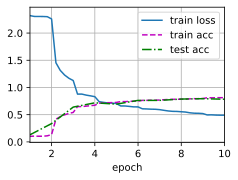

In [7]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [9]:
# class LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(1,6, kernel_size = 5, padding = 2), nn.Sigmoid(),
                        nn.AvgPool2d(kernel_size = 2, stride = 2),
                        nn.Conv2d(6,16, kernel_size = 5),nn.Sigmoid(),
                        nn.AvgPool2d(kernel_size = 2, stride = 2),nn.Flatten())
        self.fc = nn.Sequential(nn.Linear(16*5*5, 120),nn.Sigmoid(),
                nn.Linear(120, 84),nn.Sigmoid(),
                nn.Linear(84, 10))
    def forward(self, X):
        feature = self.net(X) # 提取特征
        output = self.fc(feature.view(X.shape[0], -1))
        return output

In [10]:
def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
    if sys.platform.startswith('win'): # win系统
        num_workers = 0
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers = num_workers)
    return train_iter, test_iter

In [13]:
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')